In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os
import random

from hparams import hparams, hparams_debug_string
from models.StarGAN_VC2 import Generator, Discriminator 
from optimizers import RAdam
from dataloader import VoiceDataset, ToTensor, RandomCrop
from utils import World, Converter


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
log_dir = "./log"
data_dir = "./data"
generator_name ="generator"
discriminator_name ="discriminator"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [4]:
generator = Generator()
generator.to(device)
discriminator = Discriminator()
discriminator.to(device)
if os.path.exists(os.path.join(log_dir, generator_name)):
    generator.load_state_dict(torch.load(os.path.join(log_dir, generator_name), map_location=device))
if os.path.exists(os.path.join(log_dir, discriminator_name)):
    discriminator.load_state_dict(torch.load(os.path.join(log_dir, discriminator_name), map_location=device))

In [5]:
dataset = VoiceDataset(root_dir=data_dir, source_limit=hparams.source_limit,
                                           transform=transforms.Compose([
                                               RandomCrop(),
                                               ToTensor(),
                                           ]))
dataloader = DataLoader(dataset, batch_size=hparams.batch_size, shuffle=hparams.shuffle, drop_last=True)

['hiroshiba', 'uemura', 'tanezaki', 'tsuchiya', 'fujitou']
[hiroshiba] mcep loaded.
[uemura] mcep loaded.
[tanezaki] mcep loaded.
[tsuchiya] mcep loaded.
[fujitou] mcep loaded.


2903
torch.Size([1, 35, 128]) tensor(2)
tensor(2)


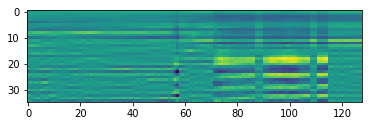

In [6]:
print(len(dataset))
data, label = dataset[np.random.randint(0,2000)]
print(data.shape, label)
plt.imshow(data[0])
print(label)

In [7]:
for i, batch in enumerate(dataloader):
    data, label = batch
    print(data.shape)
    print(data.type())
    print(label)
    onehot = torch.eye(len(dataset.speakers))[label]
    print(onehot)
    break

torch.Size([8, 1, 35, 128])
torch.FloatTensor
tensor([2, 1, 3, 4, 2, 2, 4, 4])
tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])


In [8]:
optimizer_gen = RAdam(generator.parameters(), lr=hparams.learning_rate_gen, 
                                  weight_decay=hparams.weight_decay,betas=hparams.betas)
optimizer_disc = RAdam(discriminator.parameters(), lr=hparams.learning_rate_disc, 
                                   weight_decay=hparams.weight_decay,betas=hparams.betas)

In [ ]:
def generate(generator, file_path, source_label, target_label, wav_name):
    
    with torch.no_grad():
        
        wav, _ = librosa.load(file_path, sr=hparams.fs)
        wav, _ = librosa.effects.trim(wav)
        wav = wav.astype(np.double)
        f0, spec, ap = world.analyze(wav)
        mcep = world.mcep_from_spec(spec)
        mcep = mcep.reshape(mcep.shape[0], mcep.shape[1], 1)
        mcep = mcep.transpose((2, 1, 0))
        
        convert_result = []
        for start_idx in range(0, mcep.shape[1] - 128 + 1, 128):
            
            seg = mcep[:, start_idx : start_idx+128]
            seg = torch.FloatTensor(seg).to(self.device)
            seg = one_seg.view(1,1,seg.size(0),seg.size(1))
            source_label = torch.tensor(source_label, dtype=torch.long)
            target_label = torch.tensor(target_label, dtype=torch.long)
            
            seg, source_label, target_label = seg.to(self.device), source_label.to(self.device), target_label.to(self.device)
            
            outputs = generator(seg, source_label, target_label).data.cpu().numpy()
            outputs = np.squeeze(outputs)
            outputs = converter.backward_process(outputs, target_label.data.cpu.numpy())
            convert_result.append(outputs)

        convert_con = np.concatenate(convert_result, axis=1)
        convert_con = convert_con[:, 0:content['mceps_norm'].shape[1]]
        f0_converted = converter.pitch_conversion(f0, speaker, target)
        wav = world.synthesis_from_mcep(f0_converted, mcep_converted, ap, hparams.fs)

        librosa.output.write_wav(os.path.join(log_dir, wav_name), wav, hparams.fs)            



epoch : 1
1


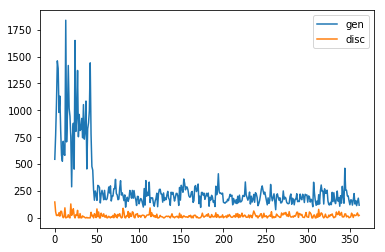

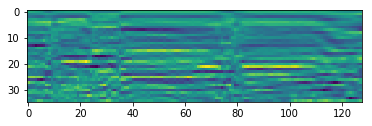

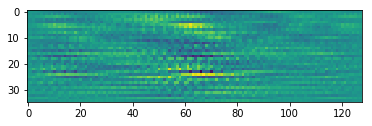

epoch : 2
2


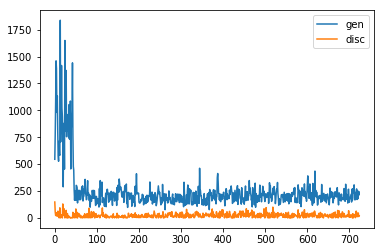

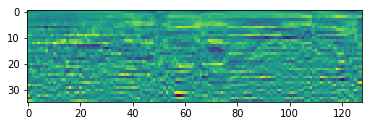

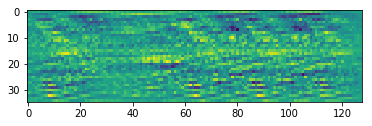

epoch : 3
3


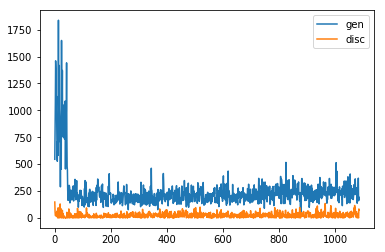

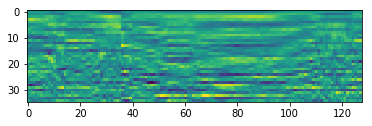

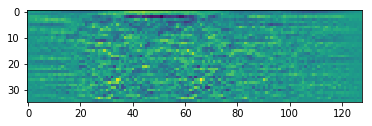

epoch : 4
4


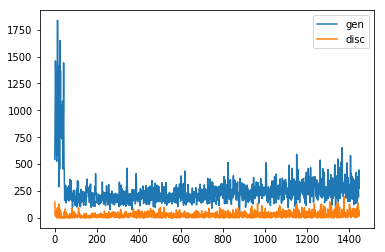

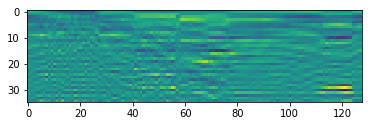

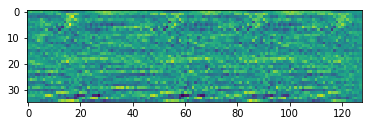

epoch : 5
5


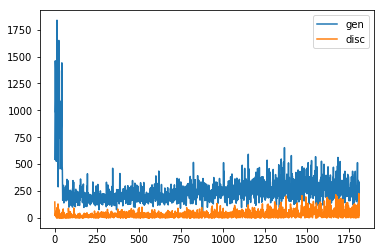

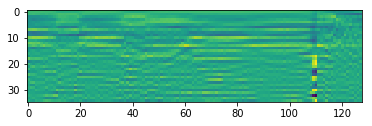

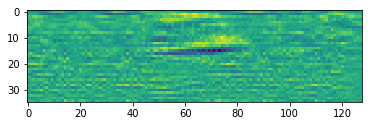

epoch : 6
6


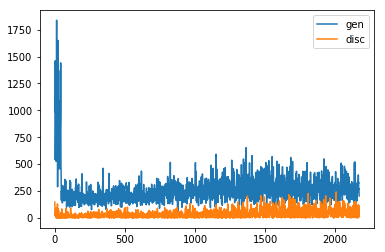

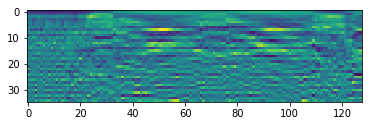

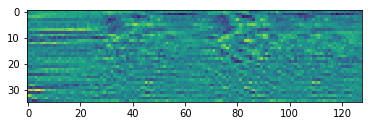

epoch : 7
7


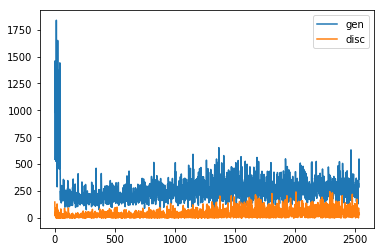

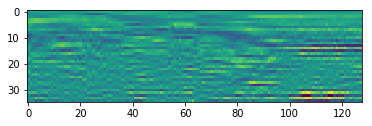

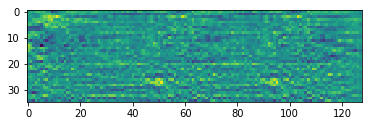

epoch : 8
8


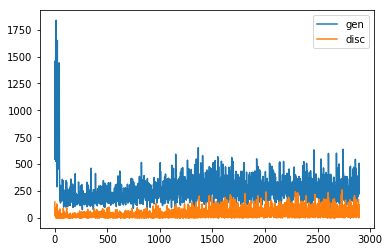

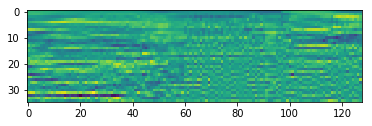

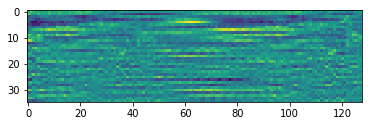

epoch : 9
9


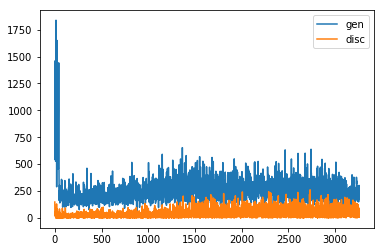

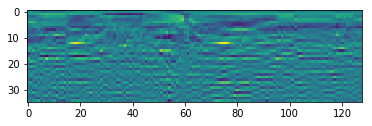

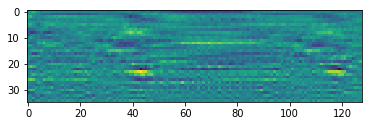

epoch : 10
10


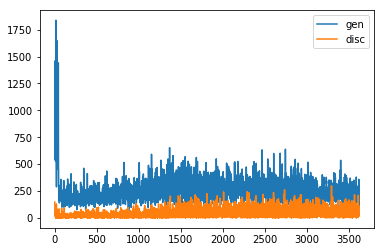

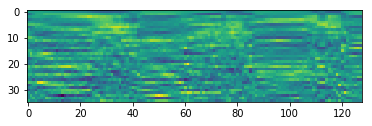

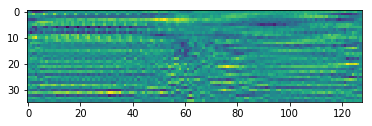

Convert from 'tsuchiya' to 'uemura'
Convert from 'hiroshiba' to 'fujitou'
Convert from 'tanezaki' to 'tsuchiya'
Convert from 'uemura' to 'tanezaki'
epoch : 11
11


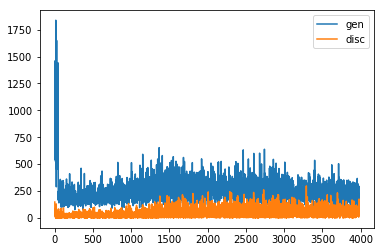

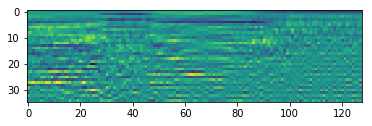

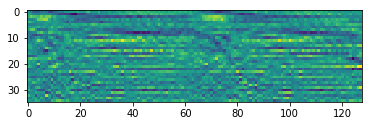

epoch : 12
12


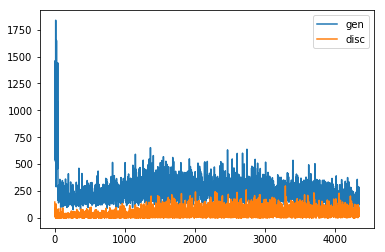

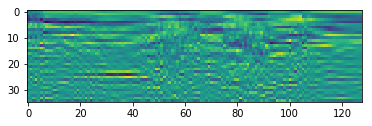

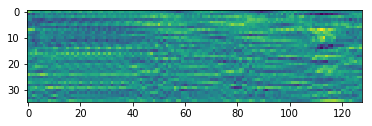

epoch : 13


In [ ]:
losses_gen = []
losses_disc = []
for epoch in range(hparams.num_epochs):
    
    print("epoch : {}".format(epoch+1))
    
    running_loss = 0.
    for i, batch in enumerate(dataloader):
        
        x_batch, y_batch = batch
        y_t_batch = (y_batch + torch.randint(0, hparams.num_classes, y_batch.shape)) % hparams.num_classes
        y_t_batch = y_t_batch.long()
        x_batch, y_batch, y_t_batch = x_batch.to(device), y_batch.to(device), y_t_batch.to(device)
        
        ### Train the discriminator ###
        criterion_disc = nn.BCELoss()
        out_disc_real = discriminator(x_batch, y_t_batch, y_batch)
        out_gen = generator(x_batch, y_batch, y_t_batch)
        out_disc_fake = discriminator(out_gen.detach(), y_batch, y_t_batch)
        
        loss_disc = F.binary_cross_entropy_with_logits(out_disc_fake,torch.zeros_like(out_disc_fake, dtype=torch.float)) + \
                                        F.binary_cross_entropy_with_logits(out_disc_real, torch.ones_like(out_disc_real, dtype=torch.float))
            
        loss_disc.backward()
        optimizer_disc.step()
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()
        
        ### Train the Generator ###
        out_gen = generator(x_batch, y_batch, y_t_batch)
        out_disc_fake = discriminator(out_gen, y_batch, y_t_batch)
        
        # Adversarial loss
        loss_adv = F.binary_cross_entropy_with_logits(out_disc_fake, torch.ones_like(out_disc_fake, dtype=torch.float))
        
        # Cycle-consistency loss
        gen_out_cyc = generator(generator(x_batch, y_batch, y_t_batch), y_t_batch, y_batch)
        loss_cyc = F.l1_loss(gen_out_cyc, x_batch)

        # Identity-mapping loss
        gen_out_id = generator(x_batch, y_batch, y_batch)
        loss_id = F.l1_loss(gen_out_id, x_batch)

        if epoch < 10:
            loss_gen = loss_adv + 10 * loss_cyc + 5 * loss_id
        else:
            loss_gen = loss_adv + 10 * loss_cyc 
            
        loss_gen.backward()
        optimizer_gen.step()
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()
        
        losses_disc.append(loss_disc.item())
        losses_gen.append(loss_gen.item())
        
    if (epoch+1)%1==0:
        print(epoch+1)
        plt.plot(losses_gen, label="gen")
        plt.plot(losses_disc, label="disc")
        plt.legend()
        plt.savefig(os.path.join(log_dir, "loss.png"))
        plt.show()
        img = x_batch[0].cpu().detach().numpy()
        plt.imshow(img[0])
        plt.savefig(os.path.join(log_dir, "source.png".format(epoch+1)))
        plt.show()
        img = out_gen[0].cpu().detach().numpy()
        plt.imshow(img[0])
        plt.savefig(os.path.join(log_dir, "output.png".format(epoch+1)))
        plt.show()
        
    if (epoch+1)%10==0:
        torch.save(generator.state_dict(), os.path.join(log_dir, generator_name))
        torch.save(discriminator.state_dict(), os.path.join(log_dir, discriminator_name))
               
    if (epoch+1)%10==0:
        # test generate
        speakers = ['hiroshiba', 'uemura', 'tanezaki', 'tsuchiya', 'fujitou']
        for i in range(4):
            s_label, t_label = random.sample(speakers, 2)
            if not os.path.exists(os.path.join(log_dir, "epoch_{:04d}".format(epoch+1))):
                os.makedirs(os.path.join(log_dir, "epoch_{:04d}".format(epoch+1)))
            save_path = os.path.join(os.path.join(log_dir, "epoch_{:04d}".format(epoch+1)), "{}_to_{}.wav".format(s_label, t_label))
            dataset.converter.generate(generator, s_label, t_label, save_path)


In [ ]:
def load_model(log_dir, model_name):
    model = AutoEncoder()
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(os.path.join(model_dir, model_name), map_location=device))
    return model

In [ ]:
world = World(fs=hparams.fs, fftl=hparams.fftl, shiftms=hparams.shiftms, minf0=hparams.minf0, maxf0=hparams.maxf0)

In [ ]:
x_batch.type(), y_batch.type(), y_t_batch .type()

In [ ]:
np.matmul(np.ones((8, 10, 512)),np.ones((8,512, 1))).shape

In [ ]:
h = torch.ones((3,3)).dim()
h

In [ ]:
speakers = ['hiroshiba', 'uemura', 'tanezaki', 'tsuchiya', 'fujitou']
s_label, t_label = speakers.sample(2)

In [ ]:
import glob

In [ ]:
np.concatenate([np.zeros((100, 20)), np.zeros((120, 20))]).shape